#  XGB Model

In [1]:
import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from joblib import dump, load  # for saving models

In [2]:
from automl import *

In [3]:
import gc
import GPUtil

In [4]:
# MANIFEST - list of versions on board 
print_manifest()

2020-02-21 15:48:02.709446
OS: Linux
Python: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
matplotlib: 3.1.3
numpy: 1.18.1
pandas: 1.0.1
sklearn: 0.22.1
xgboost: 0.90


/home/user/mortality/omop-cdm-postgresql/automl.py:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print(pd.datetime.now())


In [5]:
# https://askubuntu.com/questions/5417/how-to-get-the-gpu-info
# might want to conditinally set the 'tree_method' parameter to xbgoost based on the return to this call
! lspci  -v -s  $(lspci | grep ' VGA ' | cut -d" " -f 1) | grep 'controller'

01:00.0 VGA compatible controller: NVIDIA Corporation GP102 [GeForce GTX 1080 Ti] (rev a1) (prog-if 00 [VGA controller])


## Data Prep

In [6]:
OUR_NA = -999  # could be better than 0 for XGB

In [7]:
FOLDER = '../mortality_prediction_docker_model/v2/scratch/'
train_file = FOLDER+'train_death_last.csv.gz'
# train_file = FOLDER+'train_all.csv.gz'

train = pd.read_csv(train_file, low_memory=False)
train.shape

FileNotFoundError: [Errno 2] No such file or directory: '../mortality_prediction_docker_model/v2/scratch/train_death_last.csv.gz'

In [36]:
train.head()

,race_concept_id,death_in_next_window,number_of_visits,old,gender_concept_id,race_concept_name,visit_concept_name,visit_duration,person_id,ethnicity_concept_id,...,observation_concept_id_list_2617939,observation_concept_id_list_4015724,observation_concept_id_list_40663262,observation_concept_id_list_4214956,observation_concept_id_list_432507,observation_concept_id_list_434237,observation_concept_id_list_439615,observation_concept_id_list_440927,observation_concept_id_list_442941,observation_type_concept_id_list_38000282
0,8552.0,0,2,87.0,8507,Unknown,1,0,0,NaN,...,0,1,0,0,0,0,0,1,0,1
1,8557.0,0,6,75.0,8507,Native Hawaiian or Other Pacific Islander,2,0,5,NaN,...,0,0,0,0,0,0,0,0,0,0
2,8527.0,0,4,34.0,8532,White,1,1,6,NaN,...,0,1,0,1,0,0,0,1,0,1
3,8657.0,0,1,72.0,8532,American Indian or Alaska Native,0,0,7,38003564.0,...,0,0,0,0,0,0,0,0,0,0
4,8657.0,0,1,76.0,8532,American Indian or Alaska Native,0,0,8,38003564.0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
max_non_concept = 19 # set this to the column # prior to concepts column names
cols = pd.DataFrame([[c.split('_')[-1] for c in train.columns],train.columns]).T
cols.columns =['concept_id','column']
cols.concept_id[0:max_non_concept] = 0 # the first are strings
cols.concept_id = cols.concept_id.astype(int)
cols.iloc[max_non_concept-1:max_non_concept+5]

,concept_id,column
18,0,days_since_latest_observation
19,135939,condition_concept_id_list_135939
20,140673,condition_concept_id_list_140673
21,192273,condition_concept_id_list_192273
22,193249,condition_concept_id_list_193249
23,193308,condition_concept_id_list_193308


In [63]:
all_concepts = pd.read_csv('v2/app/concept_codes_final/all_concepts.csv')
all_concepts.head()

,concept_id,concept_name,vocabulary_id,table
0,3000453,Epstein Barr virus DNA [#/volume] (viral load)...,LOINC,measurement
1,3000515,Antithrombin actual/normal in Platelet poor pl...,LOINC,measurement
2,3000722,Carnitine free (C0) [Moles/volume] in Serum or...,LOINC,measurement
3,3001405,CD3+CD8+ (T8 suppressor cells) cells [#/volume...,LOINC,measurement
4,3001599,Carotene [Mass/volume] in Serum,LOINC,measurement


In [64]:
col_concepts = cols.set_index('concept_id').join(all_concepts.set_index('concept_id'), how='left')
col_concepts.head()

,column,concept_name,vocabulary_id,table
concept_id,,,,
0,race_concept_id,NaN,NaN,NaN
0,death_in_next_window,NaN,NaN,NaN
0,number_of_visits,NaN,NaN,NaN
0,old,NaN,NaN,NaN
0,gender_concept_id,NaN,NaN,NaN


In [65]:
col_concepts.tail()

,column,concept_name,vocabulary_id,table
concept_id,,,,
40664421,procedure_concept_id_list_40664421,NaN,NaN,NaN
42708698,drug_concept_id_list_42708698,NaN,NaN,NaN
42709184,drug_concept_id_list_42709184,NaN,NaN,NaN
42901904,drug_concept_id_list_42901904,NaN,NaN,NaN
46287422,drug_concept_id_list_46287422,NaN,NaN,NaN


In [66]:
# What % oc concept_id's don't have a corresponding concept code?
round(col_concepts.isnull().sum().table / col_concepts.shape[0], 2)*100

74.0

In [67]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train.race_concept_name = train.race_concept_name.replace(to_replace=OUR_NA, value='Unknown')
train.race_concept_name = train.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(train.race_concept_name)
train.race_concept_name = label_encoder.transform(train.race_concept_name)

In [68]:
from sklearn.preprocessing import LabelEncoder

categoricals = ['ethnicity_concept_id',
               'gender_concept_id',
               'race_concept_id',
               'condition_status_concept_id',
               'race_concept_name']

for c in categoricals:
    le = LabelEncoder()
    train[c]=le.fit_transform(train[c])

In [69]:
start_mem = train.memory_usage().sum() / 1024**2
print('Memory usage is {:.2f} MB'.format(start_mem))

Memory usage is 155.38 MB


In [70]:
train = train.fillna(OUR_NA)
train = cols_toint(train)

In [71]:
%%time
train = reduce_mem_usage(train)

Memory usage of dataframe is 155.38 MB
Memory usage after optimization is: 21.20 MB
Decreased by 86.4%
CPU times: user 2.27 s, sys: 224 ms, total: 2.49 s
Wall time: 2.49 s


In [72]:
train.head()

,race_concept_id,death_in_next_window,number_of_visits,old,gender_concept_id,race_concept_name,visit_concept_name,visit_duration,person_id,ethnicity_concept_id,...,observation_concept_id_list_2617939,observation_concept_id_list_4015724,observation_concept_id_list_40663262,observation_concept_id_list_4214956,observation_concept_id_list_432507,observation_concept_id_list_434237,observation_concept_id_list_439615,observation_concept_id_list_440927,observation_concept_id_list_442941,observation_type_concept_id_list_38000282
0,3,False,2,87,False,4,1,0,0,13149,...,False,True,False,False,False,False,False,True,False,True
1,4,False,6,75,False,3,2,0,5,23132,...,False,False,False,False,False,False,False,False,False,False
2,2,False,4,34,True,5,1,1,6,23133,...,False,True,False,True,False,False,False,True,False,True
3,5,False,1,72,True,0,0,0,7,1,...,False,False,False,False,False,False,False,False,False,False
4,5,False,1,76,True,0,0,0,8,1,...,False,False,False,False,False,False,False,False,False,False


In [20]:
# %%time
# # expensive, don't do this if you don't have time
# find_dup_cols(train)

In [21]:
# # there are no duplicates
# train_nodup = train.drop_duplicates()
# train_nodup.shape

In [73]:
train_describe_df = train[:30].describe(include='all').T.fillna('')
train_describe_df[:30]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
race_concept_id,30.0,,,,63.0333,187.834,0,2,3,4,778
death_in_next_window,30.0,1,False,30,,,,,,,
number_of_visits,30.0,,,,2.3,1.62205,1,1,2,3,7
old,30.0,,,,74.2333,11.3188,34,69,75.5,78,97
gender_concept_id,30.0,2,False,16,,,,,,,
race_concept_name,30.0,,,,3,1.57568,0,2,3.5,4,5
visit_concept_name,30.0,,,,0.433333,0.727932,0,0,0,1,3
visit_duration,30.0,,,,0.1,0.402578,0,0,0,0,2
person_id,30.0,,,,25.8333,15.1181,0,12.25,25.5,40.25,49
ethnicity_concept_id,30.0,,,,10465.3,11517.6,1,1,1,23136.8,23144


In [31]:
train.shape

(278998, 234)

In [32]:
# select features
drop_features = ['death_in_next_window', 'window_id','person_id']

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

## Test 

In [58]:
test_file = FOLDER+'test_all_target.csv.gz'
test = pd.read_csv(test_file,low_memory = False)
test.shape

(118781, 232)

In [59]:
test = cols_toint(test)
test.shape

(118781, 232)

In [60]:
test.race_concept_name = test.race_concept_name.replace(to_replace=0, value='Unknown')
test.race_concept_name = test.race_concept_name.fillna('Unknown')
test.race_concept_name = label_encoder.transform(test.race_concept_name)

In [104]:
X_test = test.drop(drop_features, axis = 1)
X_test = X_test[train_features]  # order the test columns like train
test_features = X_test.columns.values
X_test = np.array(X_test)

In [106]:
y_test = test.death_in_next_window
X_test.shape, y_test.shape

((118781, 229), (118781,))

## Feature Selection

In [249]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [261]:
# from sklearn.model_selection import StratifiedShuffleSplit

# #from sklearn.model_selection import train_test_split
# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

# for train_index, valid_index in sss.split(X, y):
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

In [262]:
%%time
clf_et = ExtraTreesClassifier(n_estimators=500, max_depth=40, random_state=random_state)
clf_et = clf.fit(X, y)

(18191, 11921) (18191,)
CPU times: user 1min 29s, sys: 44 ms, total: 1min 29s
Wall time: 1min 29s


In [263]:
ET_feat_importance = pd.DataFrame([train_features, clf_et.feature_importances_]).T
ET_feat_importance.columns = ['feature','importance']
ET_feat_importance = ET_feat_importance.sort_values(by='importance', ascending=False)
ET_feat_importance.head(20)

,feature,importance
3,number_of_visits,0.0197456
1,visit_concept_name,0.0125517
10,outpatient_visit_count,0.0103247
8686,drug_concept_id_list_19019626,0.0101682
7,old,0.006326
12,total_quantity_of_drugs,0.00571369
4634,procedure_concept_id_list_2001510,0.00545314
8625,drug_concept_id_list_19018901,0.00544711
8920,drug_concept_id_list_19048000,0.00541019
6290,procedure_concept_id_list_2106033,0.00534228


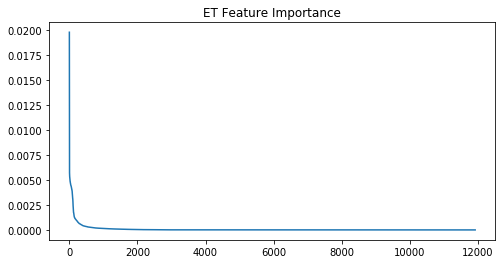

In [264]:
ax=ET_feat_importance.importance.plot(use_index=False, figsize=(8,4), title='ET Feature Importance')

In [265]:
(ET_feat_importance.importance > 0.001).sum()

200

In [266]:
%%time
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=40,  random_state=random_state,)
clf_rf = clf.fit(X, y)

CPU times: user 1min 28s, sys: 40 ms, total: 1min 28s
Wall time: 1min 28s


In [267]:
RF_feat_importance = pd.DataFrame([train_features, clf_rf.feature_importances_]).T
RF_feat_importance.columns = ['feature','importance']
RF_feat_importance = RF_feat_importance.sort_values(by='importance', ascending=False)
RF_feat_importance.head(20)

,feature,importance
3,number_of_visits,0.0189775
10,outpatient_visit_count,0.0120984
8686,drug_concept_id_list_19019626,0.0115855
1,visit_concept_name,0.011547
12,total_quantity_of_drugs,0.00631756
7,old,0.00613483
4634,procedure_concept_id_list_2001510,0.00574478
6,race_concept_id,0.0053868
424,condition_concept_id_list_193308,0.00536428
9388,drug_concept_id_list_19122875,0.00524866


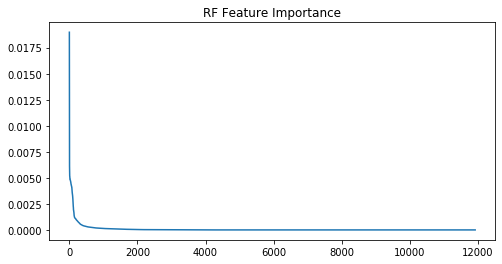

In [268]:
ax=RF_feat_importance.importance.plot(use_index=False, figsize=(8,4), title='RF Feature Importance')

In [269]:
(RF_feat_importance.importance > 0.001).sum()

198

In [275]:
ET_feat_importance.head()

,feature,importance
3,number_of_visits,0.0197456
1,visit_concept_name,0.0125517
10,outpatient_visit_count,0.0103247
8686,drug_concept_id_list_19019626,0.0101682
7,old,0.006326


In [278]:
inET = list(set(ET_feat_importance.iloc[:210].index) - set(RF_feat_importance.iloc[:210].index))
ET_feat_importance.loc[inET].sort_values(by='importance', ascending=False)

,feature,importance
11232,drug_concept_id_list_938045,0.00132154
7630,procedure_concept_id_list_2314290,0.00114595
8511,drug_concept_id_list_1742258,0.001112
10814,drug_concept_id_list_42708698,0.00109642
7679,procedure_concept_id_list_2414395,0.00106649
3881,condition_concept_id_list_75637,0.00106336
4867,procedure_concept_id_list_2003090,0.00104316
6277,procedure_concept_id_list_2105956,0.00103364
8031,procedure_type_concept_id_list_38000251,0.00102705
7764,procedure_concept_id_list_2617177,0.00102002


In [280]:
inRF = list(set(RF_feat_importance.iloc[:210].index) - set(ET_feat_importance.iloc[:210].index))
RF_feat_importance.loc[inRF].sort_values(by='importance', ascending=False)

,feature,importance
75,condition_concept_id_list_133697,0.00125315
9966,drug_concept_id_list_40168604,0.00121321
3893,condition_concept_id_list_75900,0.00120535
5828,procedure_concept_id_list_2101659,0.00119505
11188,drug_concept_id_list_917310,0.00115739
5618,procedure_concept_id_list_2007830,0.00113427
389,condition_concept_id_list_192671,0.00112068
2701,condition_concept_id_list_435784,0.00110087
7317,procedure_concept_id_list_2213601,0.00109428
4495,procedure_concept_id_list_2001198,0.00107115


In [281]:
model = SelectFromModel(clf, prefit=True, max_features=200, threshold='median')
X_new = model.transform(X)
X_new.shape               

(18191, 200)

In [287]:
top_features = ET_feat_importance[ET_feat_importance.importance > 0.001].feature.to_list()

In [288]:
top_features = [f.replace('id_list_','') for f in top_features]

In [291]:
top_file= open("top_features.txt","w+")
for line in top_features:
    top_file.write(line)
top_file.close()

In [295]:
!ls top_features.txt; ls features.txt

top_features.txt
features.txt


In [299]:
orig_features = [line.rstrip('\n') for line in open('features.txt')]

In [303]:
print(len(top_features), len(orig_features))
len(set(top_features) - set(orig_features))

200 247


183

## Load Selected Features

In [76]:
train_file = FOLDER+'train_all.csv.gz'
train = pd.read_csv(train_file,low_memory = False)
train.shape

(278998, 232)

In [77]:
train.head()

,days_since_latest_visit,death_in_next_window,person_id,visit_duration,number_of_visits,race_concept_name,race_concept_id,old,visit_concept_name,gender_concept_id,...,observation_concept_id_list_40757059,observation_concept_id_list_4081756,observation_concept_id_list_4176605,observation_concept_id_list_4186037,observation_concept_id_list_4192270,observation_concept_id_list_4214956,observation_concept_id_list_43021378,observation_concept_id_list_4305831,observation_concept_id_list_433942,observation_type_concept_id_list_38000282
0,45,0,0,0,4,Unknown,8552.0,84.0,0,8507,...,0,0,0,0,0,1,0,0,0,1
1,31,0,5,0,1,Native Hawaiian or Other Pacific Islander,8557.0,72.0,1,8507,...,0,0,0,0,0,0,0,0,0,0
2,103,0,6,0,3,White,8527.0,31.0,0,8532,...,0,0,0,0,0,0,0,0,0,1
3,84,0,10,0,1,Unknown,8552.0,71.0,0,8532,...,0,0,0,0,0,0,0,0,0,0
4,2,0,12,0,2,Black or African American,8516.0,88.0,0,8532,...,0,0,0,0,0,0,0,0,0,0


In [78]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train.race_concept_name = train.race_concept_name.replace(to_replace=OUR_NA, value='Unknown')
train.race_concept_name = train.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(train.race_concept_name)
train.race_concept_name = label_encoder.transform(train.race_concept_name)

In [79]:
from sklearn.preprocessing import LabelEncoder

categoricals = ['ethnicity_concept_id',
               'gender_concept_id',
               'race_concept_id',
               'condition_status_concept_id',
               'race_concept_name']

for c in categoricals:
    le = LabelEncoder()
    train[c]=le.fit_transform(train[c])

In [80]:
start_mem = train.memory_usage().sum() / 1024**2
print('Memory usage is {:.2f} MB'.format(start_mem))

Memory usage is 493.83 MB


In [81]:
train = train.fillna(OUR_NA)
train = cols_toint(train)

In [82]:
%%time
train = reduce_mem_usage(train)

Memory usage of dataframe is 493.83 MB
Memory usage after optimization is: 67.58 MB
Decreased by 86.3%
CPU times: user 4.99 s, sys: 3.23 s, total: 8.22 s
Wall time: 8.22 s


In [83]:
train.head()

,days_since_latest_visit,death_in_next_window,person_id,visit_duration,number_of_visits,race_concept_name,race_concept_id,old,visit_concept_name,gender_concept_id,...,observation_concept_id_list_40757059,observation_concept_id_list_4081756,observation_concept_id_list_4176605,observation_concept_id_list_4186037,observation_concept_id_list_4192270,observation_concept_id_list_4214956,observation_concept_id_list_43021378,observation_concept_id_list_4305831,observation_concept_id_list_433942,observation_type_concept_id_list_38000282
0,45,False,0,0,4,4,3,84,0,False,...,False,False,False,False,False,True,False,False,False,True
1,31,False,5,0,1,3,4,72,1,False,...,False,False,False,False,False,False,False,False,False,False
2,103,False,6,0,3,5,2,31,0,True,...,False,False,False,False,False,False,False,False,False,True
3,84,False,10,0,1,4,3,71,0,True,...,False,False,False,False,False,False,False,False,False,False
4,2,False,12,0,2,2,1,88,0,True,...,False,False,False,False,False,False,False,False,False,False


## XGB Model

In [85]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 15,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 500,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.7,
    'subsample' : 1.0,
    'missing': OUR_NA,
}

In [86]:
# %%time
drop_features = ['death_in_next_window', 'window_id', 'person_id']
window = {}
xgb_model = None # clear out the xgb_model
for w in train.window_id.unique():
    X = train[train.window_id == w] #[train.columns[:50]].copy()
    y = train[train.window_id == w].death_in_next_window
    window[w] = {'size': y.shape[0], 'deaths': y.sum()}
    X = X.drop(drop_features, axis=1)
    train_features = X.columns.values
    X = np.array(X)
    y = np.array(y).ravel()
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    cv_scores = {}
    for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        evals_result ={}
        # Convert our data into XGBoost format
        d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
        d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]

        xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                              evals=watchlist, evals_result=evals_result, 
                              early_stopping_rounds=early_stop, verbose_eval=False,
                              xgb_model= xgb_model,
                              callbacks=[ xgb_progressbar(num_round),]) # use either the progress bar or the plot
                                         # plot_perf_i(evals_result)]) 
        cv_scores[i] = {'best_score': xgb_model.best_score, 
                        'best_iteration': xgb_model.best_iteration, 
                        'best_ntree_limit': xgb_model.best_ntree_limit,
                        'evals_result': evals_result}

        print("Best Score:%f, best iteration:%d, best ntree:%d" % 
              (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))
        window[w].update(cv_scores)
        # GPUtil.showUtilization()
        gc.collect()

Best Score:0.589139, best iteration:93, best ntree:94



Best Score:0.641125, best iteration:3, best ntree:4


Best Score:0.641125, best iteration:3, best ntree:4



Best Score:0.681672, best iteration:16, best ntree:17



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



In [91]:
# prep a df to plot the learning curve
w_df = pd.DataFrame(window)
w_df.loc['cv_av_score'] = 0
w_df.loc['cum_size'] = 0

for j in w_df.columns:
    cv_av_score = 0
    for i in range(2):
        cv_av_score += w_df.loc[i,j]['best_score']
    cv_av_score = cv_av_score / 3
    w_df.loc['cv_av_score',j] = cv_av_score
w_df

for j in w_df.columns:
    if j != 0:
        w_df.loc['cum_size',j] = w_df.loc['size',j] + w_df.loc['cum_size',j-1] 
    else:
        w_df.loc['cum_size',j] = w_df.loc['size',j]

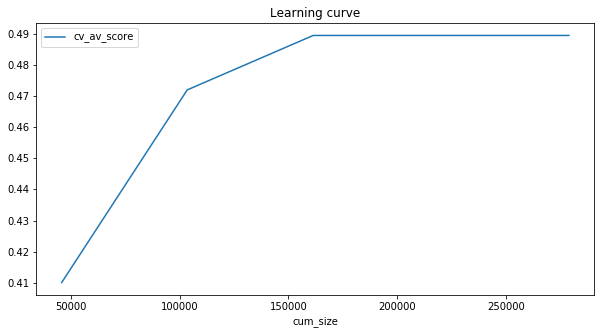

In [92]:
ax = w_df.T.plot(x='cum_size', y='cv_av_score', figsize=(10,5), title='Learning curve')

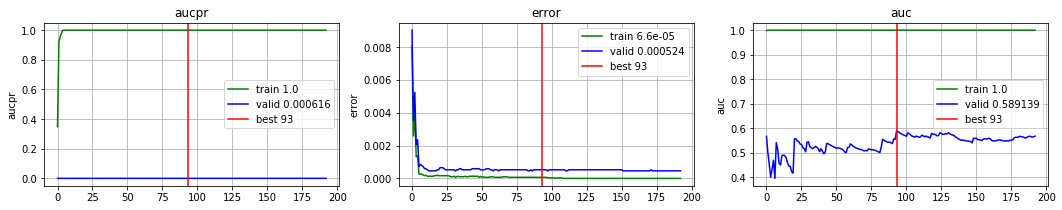

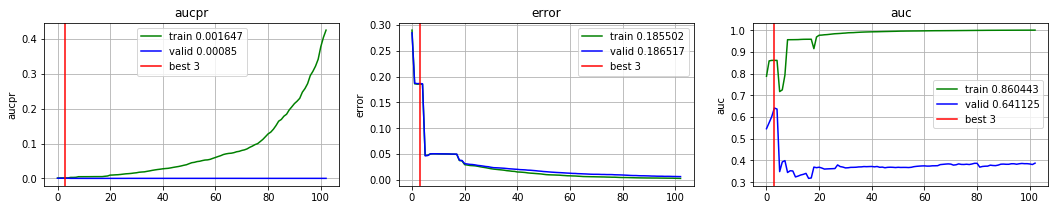

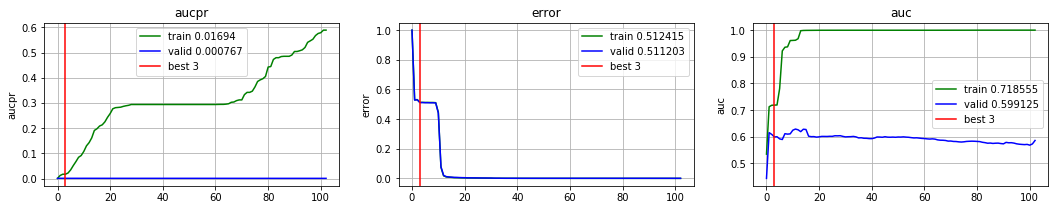

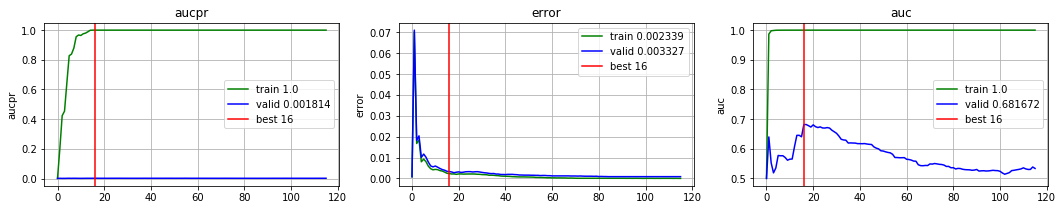

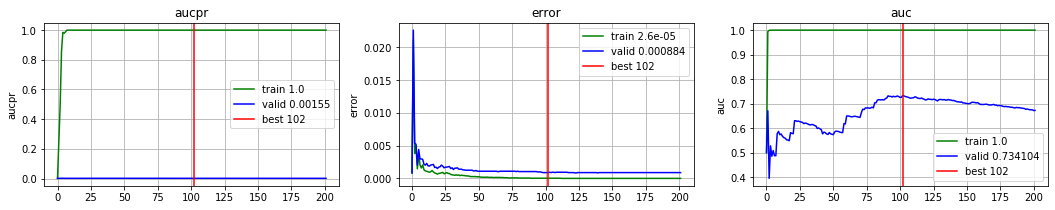

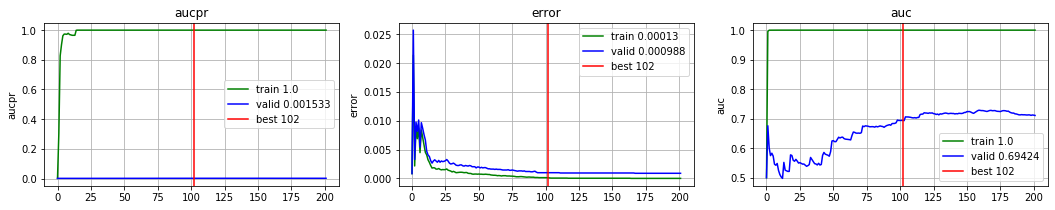

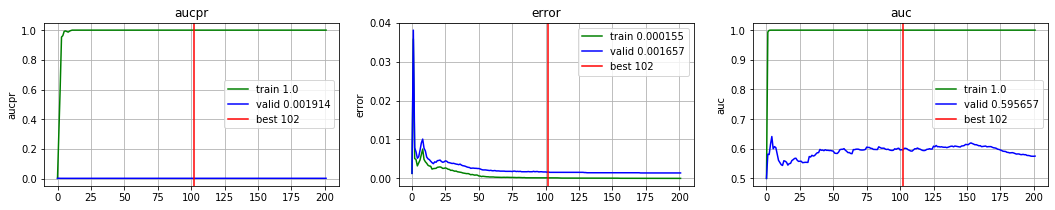

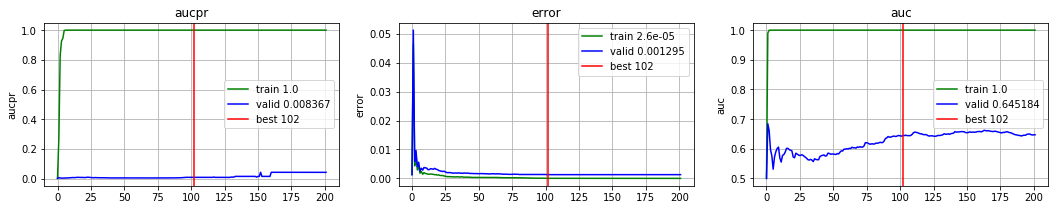

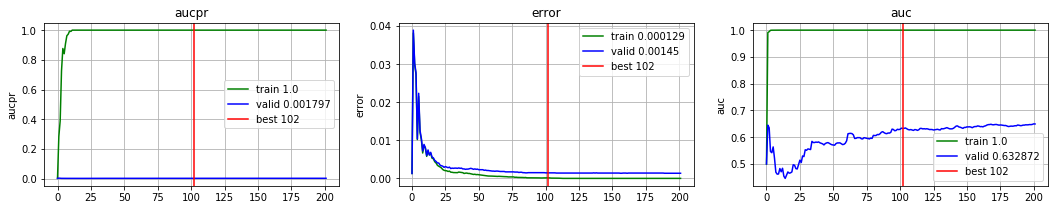

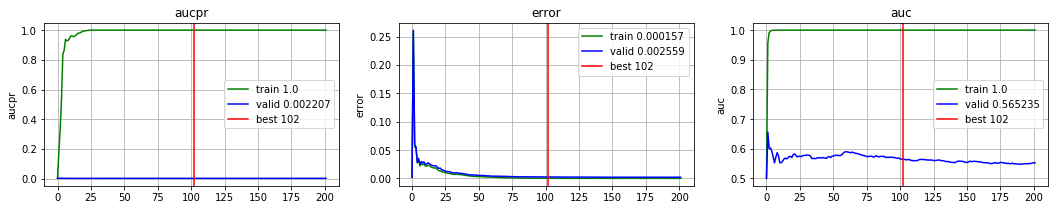

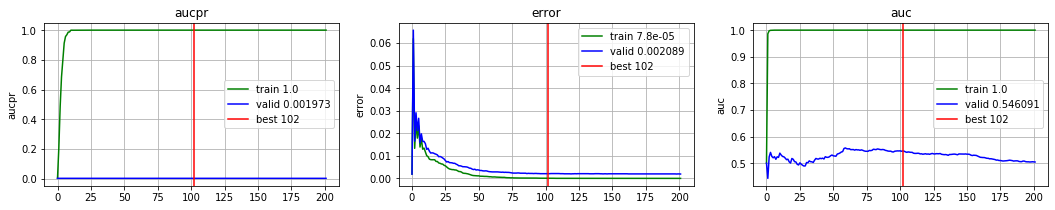

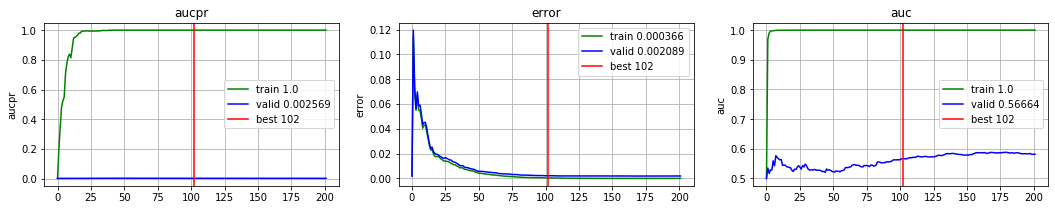

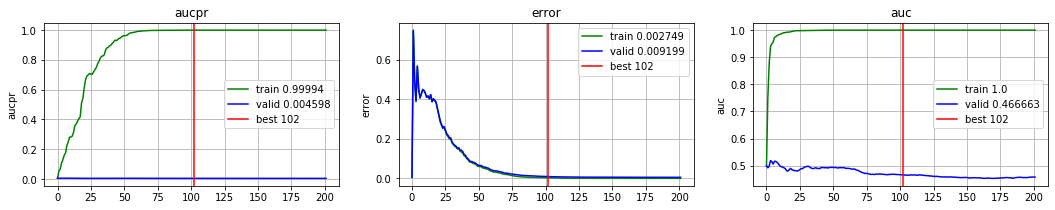

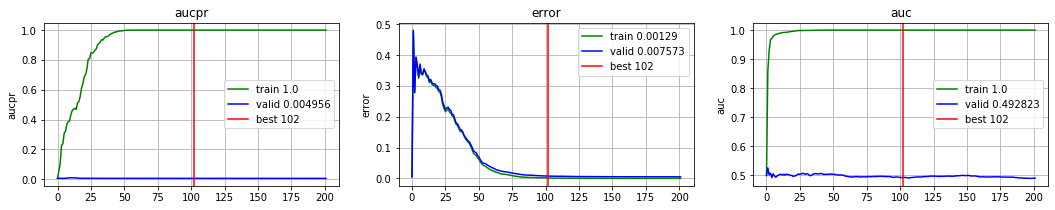

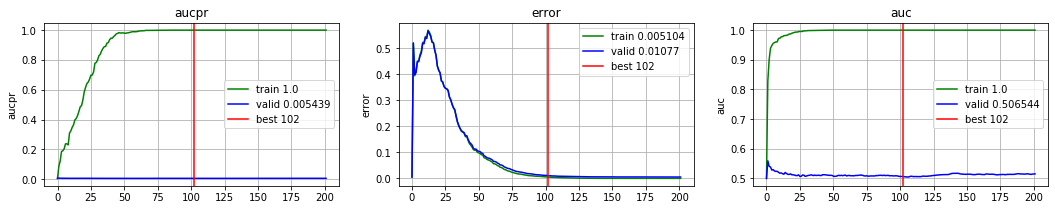

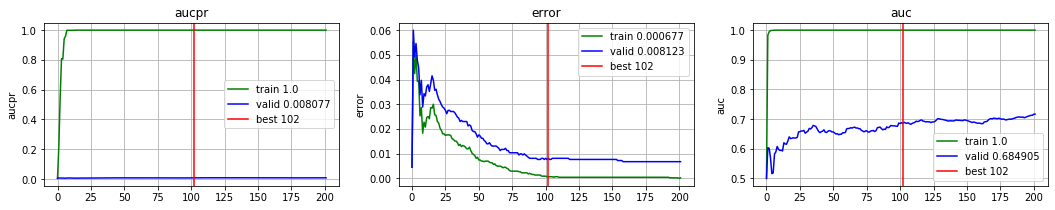

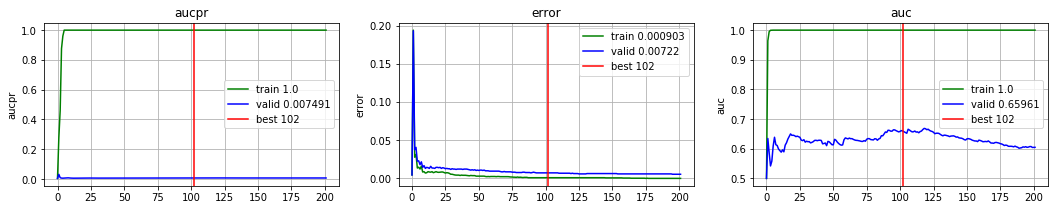

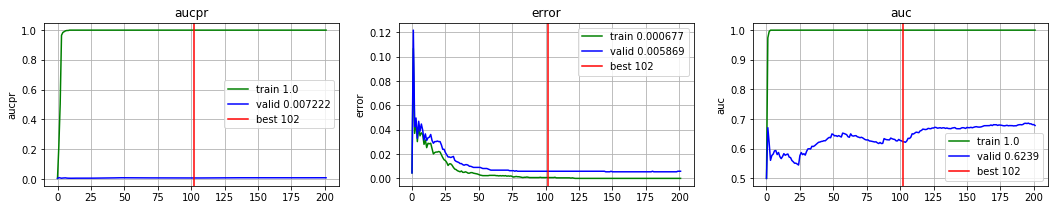

In [93]:
for w in w_df.columns:
    for i in [0,1,2]:
        plot_perf(w_df.loc[i,w]['evals_result'], w_df.loc[i,w]['best_iteration'])

In [42]:
best_tree = xgb_model.best_ntree_limit
train_preds = xgb_model.predict(d_train, ntree_limit=best_tree)
valid_preds = xgb_model.predict(d_valid, ntree_limit=best_tree)

In [43]:
best_tree

103

In [44]:
from sklearn.metrics import roc_auc_score, auc
# from sklearn.metrics import plot_roc_curve  # only sklearn after version 0.22 
# from sklearn.metrics import precision_recall_curve
# from scikitplot.metrics import plot_precision_recall_curve
# from sklearn.metrics import average_precision_score

In [45]:
print('Train AUC = ',roc_auc_score(y_train, train_preds))
print('Valid AUC = ',roc_auc_score(y_valid, valid_preds))

Train AUC =  0.4564029918404352
Valid AUC =  0.42165532879818596


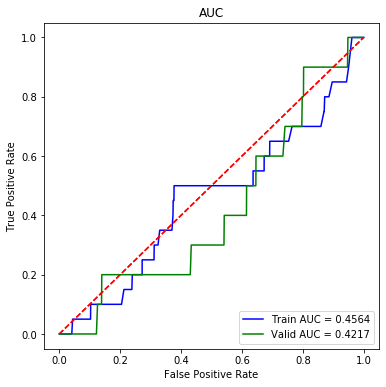

In [46]:
ax = buildROC(y_train, train_preds, label='Train')
ax = buildROC(y_valid, valid_preds, label='Valid', color='g')

## XGB CV

In [84]:
# select features
drop_features = ['death_in_next_window', 'window_id', 'person_id']
X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

In [48]:
# %%time
# another way to calc CV, but no model is returned or retained
#
d_train = xgb.DMatrix(X, y, feature_names=train_features)

cv_scores = xgb.cv(params=params, dtrain=d_train, num_boost_round=num_round, nfold=3, stratified=True,
                    metrics=metrics, early_stopping_rounds=early_stop, verbose_eval=False,
                    callbacks=[ xgb_progressbar(num_round),])
cv_scores

,train-auc-mean,train-auc-std,train-aucpr-mean,train-aucpr-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-aucpr-mean,test-aucpr-std,test-error-mean,test-error-std
0,0.929074,0.007627,0.091384,0.004921,0.230057,0.015063,0.683392,0.010987,0.003660,0.000300,0.231020,0.013884
1,0.957098,0.004552,0.202037,0.008661,0.157711,0.007173,0.652151,0.027607,0.004213,0.000759,0.159747,0.007510
2,0.969759,0.006189,0.248318,0.020206,0.153436,0.010402,0.669007,0.022791,0.004111,0.000495,0.155693,0.011344
3,0.977025,0.003104,0.277015,0.018578,0.169464,0.004566,0.679686,0.010491,0.004112,0.000302,0.171639,0.003947
4,0.986262,0.003484,0.360545,0.027169,0.140440,0.007805,0.678031,0.015063,0.004221,0.000458,0.142772,0.008556
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.000000,0.000000,0.999992,0.000006,0.000013,0.000007,0.635239,0.021673,0.003146,0.000147,0.002108,0.000032
496,1.000000,0.000000,0.999992,0.000006,0.000013,0.000007,0.635139,0.021728,0.003146,0.000150,0.002108,0.000032
497,1.000000,0.000000,0.999992,0.000006,0.000013,0.000007,0.635134,0.021668,0.003146,0.000148,0.002108,0.000032
498,1.000000,0.000000,0.999992,0.000006,0.000013,0.000007,0.635279,0.021614,0.003148,0.000146,0.002108,0.000032


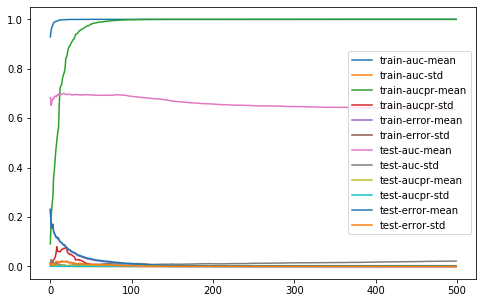

In [49]:
ax = cv_scores.plot(figsize=(8,5))

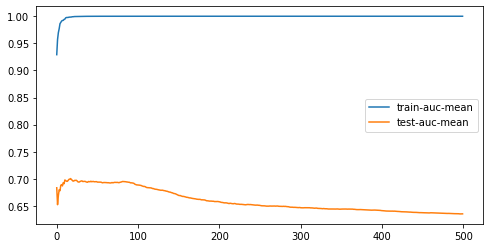

In [50]:
ax = cv_scores[['train-auc-mean','test-auc-mean']].plot(figsize=(8,4))

In [35]:
# %%time

# # I can't use the sklearn API because I get this error: ValueError: y contains previously unseen labels: 29

# from sklearn.model_selection import StratifiedKFold

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# clf = xgb.XGBClassifier(**params)

# for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

#     evals_result ={}

#     clf.fit(X_train, y_train, eval_set=[(X_valid),(y_valid)],
#             early_stopping_rounds=early_stop, verbose=False,
#             callbacks=[ xgb_progressbar(num_round),]) # use either the progress bar or the plot
#                                      # plot_perf_i(evals_result)]) 

#     print("Best Score:%f, best iteration:%d, best ntree:%d" % 
#           (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

## Train on StratifiedShuffleSPlit 20%

In [333]:
# just try the first window 
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

xgb_model = None
evals_result ={}
# Convert our data into XGBoost format
d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [334]:
xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                          evals=watchlist, evals_result=evals_result, 
                          early_stopping_rounds=early_stop, verbose_eval=False,
                          callbacks=[ xgb_progressbar(num_round),])

In [335]:
print("Best Score:%f, best iteration:%d, best ntree:%d" % 
      (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

Best Score:0.529793, best iteration:0, best ntree:1


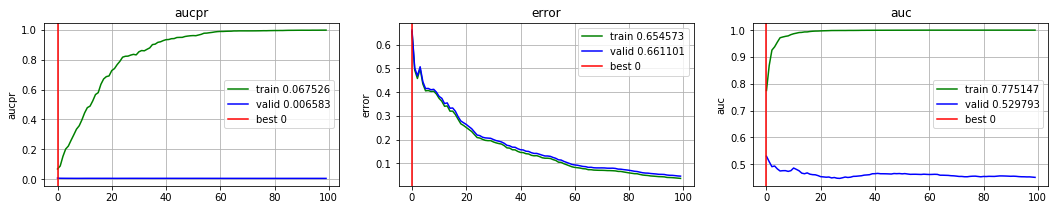

In [336]:
plot_perf(evals_result, xgb_model.best_iteration)

## RandomomizedSearchCV
 - https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [338]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [339]:
# drop_features = ['death_in_next_window', 'window_id', 'person_id']
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

In [59]:
%%time
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
# metrics = ['aucpr','error', 'auc']

space = {
    'objective':['binary:logistic'],   # in this column are values I have tried
    'booster': ['gbtree'],
    'eval_metric': ['auc'],
    'tree_method' : ['gpu_hist'],
    'random_state' : [random_state],
    'learning_rate': [0.05],           # so called `eta` value
    'reg_lambda' : [1.0],
    'min_child_weight' : [1.0],
    'max_bin' : [256],                 # [50,100,256,500]
    'min_split_loss' : [0.01],
    'max_depth' : [15],                # [10,15,20]
    'reg_alpha' : [0.0],
    'colsample_bylevel' : [1.0],
    'scale_pos_weight' : [imbalance],  # [1,round(imbalance/2),imbalance],
    'max_delta_step' : [0.0],
    'learning_rate' : [0.05],
    'n_estimators' : [1000],
    'num_parallel_tree' : [1],
    'colsample_bytree' : [0.7],        # [0.5,0.7,0.8]
    'subsample' : [1.0],               # [0.8,1.0],
    'missing': [0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
xgb_model = xgb.XGBClassifier()
# early_stopping = lambda: early_stopping_rounds=20
clf = RandomizedSearchCV(xgb_model, space, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=2, refit=True, return_train_score=True)
clf.fit(X, y)

/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  3.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.3min finished


CPU times: user 35.6 s, sys: 8.87 s, total: 44.5 s
Wall time: 3min 51s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1234, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='bi...
                                        'min_split_loss': [0.01],
                                        'missing': [0], 'n_estimators': [1000],
                                        'num_parallel_tree': [1],
                                  

In [60]:
results = pd.DataFrame(clf.cv_results_['params'])
results['test_means']  = clf.cv_results_['mean_test_score']
results['test_stds']   = clf.cv_results_['std_test_score']*2
results['train_means'] = clf.cv_results_['mean_train_score']
results['train_stds']  = clf.cv_results_['std_train_score']*2
skip_col = [c for c in results.columns if len(results[c].unique()) == 1]
display(results[results.columns.difference(skip_col)].sort_values(by='test_means', ascending=False))
print("Best parameters: ", clf.best_params_)

,max_bin,test_means,test_stds,train_means,train_stds
0,256,0.582683,0.033186,0.999861,0.000014
1,500,0.580350,0.051991,0.999861,0.000013


Best parameters:  {'tree_method': 'gpu_hist', 'subsample': 1.0, 'scale_pos_weight': 499, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'random_state': 1234, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 1000, 'missing': 0, 'min_split_loss': 0.01, 'min_child_weight': 1.0, 'max_depth': 15, 'max_delta_step': 0.0, 'max_bin': 256, 'learning_rate': 0.05, 'eval_metric': 'auc', 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'booster': 'gbtree'}


In [50]:
print("Best parameters: ", clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# pd.DataFrame([mean, stds *2])
results = pd.DataFrame(clf.cv_results_['params'])
# [c for c in results.columns if len(results[c].unique()) == 1]
skip_col = []
for c in results.columns:
    if len(results[c].unique()) == 1:  #doesn't work if c contains a list
        skip_col.append(c)

results['means'] = means
results['stds'] = stds
results[results.columns.difference(skip_col)].sort_values(by='means', ascending=False)

Best parameters:  {'tree_method': 'gpu_hist', 'subsample': 1.0, 'scale_pos_weight': 499, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'random_state': 1234, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 1000, 'missing': 0, 'min_split_loss': 0.01, 'min_child_weight': 1.0, 'max_depth': 15, 'max_delta_step': 0.0, 'max_bin': 256, 'learning_rate': 0.05, 'eval_metric': 'auc', 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'booster': 'gbtree'}
Grid scores on development set:


,colsample_bytree,max_depth,means,scale_pos_weight,stds
1,0.7,15,0.582683,499,0.016593
7,0.8,20,0.581527,499,0.015440
0,0.7,15,0.580834,1,0.014327
5,0.8,15,0.580063,499,0.017455
4,0.8,15,0.575856,1,0.012855
6,0.8,20,0.575194,1,0.014848
2,0.7,20,0.574377,1,0.014440
3,0.7,20,0.574231,499,0.019418


## SKOpt

In [53]:
# !pip install scikit-optimize

In [54]:
# import skopt
# skopt.__version__

In [55]:
# X = train[train.window_id == 1]
# y = X.death_in_next_window
# X = X.drop(drop_features, axis = 1)
# train_features = X.columns.values
# X = np.array(X)
# y = np.array(y).ravel()

In [56]:
# random_state = 1234
# num_round = 500
# early_stop = round(num_round / 5)  # 20% of the full rounds
# metrics = 'auc'                  # faster with fewer metrics to calc
# #metrics = ['aucpr','error', 'auc']

# params = {
#     'objective': 'binary:logistic',
#     'booster': 'gbtree',
#     'eval_metric': metrics,
#     'tree_method' : 'auto',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact' # gpu_hist fails with a SIGSEGV 11
#     'random_state' : random_state,
# }
# params

In [57]:
# # https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769

# from skopt import BayesSearchCV
# # Classifier
# bayes_cv_tuner = BayesSearchCV(
#     estimator = xgb.XGBClassifier(**params),
#     search_spaces = {
#         'learning_rate': (0.01, 1.0, 'log-uniform'),
#         'min_child_weight': (0, 10),
#         'max_depth': (0, 50),
#         'max_delta_step': (0, 20),
#         'subsample': (0.01, 1.0, 'uniform'),
#         'colsample_bytree': (0.01, 1.0, 'uniform'),
#         'colsample_bylevel': (0.01, 1.0, 'uniform'),
#         'reg_lambda': (1e-9, 1000, 'log-uniform'),
#         'reg_alpha': (1e-9, 1.0, 'log-uniform'),
#         'gamma': (1e-9, 0.5, 'log-uniform'),
#         'min_child_weight': (0, 5),
#         'n_estimators': (50, 100),
#         'scale_pos_weight': (1e-6, 500, 'log-uniform')
#     },    
#     scoring = 'roc_auc',
#     cv = StratifiedKFold(
#         n_splits=3,
#         shuffle=True,
#         random_state=random_state
#     ),
#     n_jobs = -1,
#     n_iter = 500,   
#     verbose = 1,
#     refit = True,
#     random_state = random_state
# )

# def status_print(optim_result):
#     """Status callback durring bayesian hyperparameter search"""
    
#     # Get all the models tested so far in DataFrame format
#     all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
#     # Get current parameters and the best parameters    
#     best_params = pd.Series(bayes_cv_tuner.best_params_)
#     print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
#         len(all_models),
#         np.round(bayes_cv_tuner.best_score_, 4),
#         bayes_cv_tuner.best_params_
#     ))
    
#     # Save all model results
#     clf_name = bayes_cv_tuner.estimator.__class__.__name__
# #    all_models.to_csv(clf_name+"_cv_results.csv")

In [58]:
# # Fit the model
# # Fails at model 10 with: ValueError: All integer values shouldbe greater than 0.000000
# result = bayes_cv_tuner.fit(X, y, callback=status_print)

## Hyperopt

In [59]:
# !pip install hyperopt

In [27]:
from hyperopt.plotting import main_plot_history, main_plot_histogram
from hyperopt import hp, fmin, atpe, tpe, Trials, STATUS_OK, STATUS_FAIL
from sklearn.metrics import roc_auc_score, auc

In [28]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
imbalance

499

In [55]:
# https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# XGB parameters
xgb_reg_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method' : 'hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'learning_rate':    0.05, # hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(10, 30, 10, dtype=int)),
#    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
#    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
#    'subsample':        hp.uniform('subsample', 0.8, 1),
#    'n_estimators':     400,
    'scale_pos_weight' : hp.choice('scale_pos_weight', [1,10,round(imbalance/2), imbalance]),

}

xgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 20,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: 1.0-roc_auc_score(y, pred)

In [49]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL, 'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [50]:
# just try the first window 
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

In [51]:
obj = HPOpt(X_train, X_valid, y_train, y_valid)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=4)

100%|██████████| 4/4 [01:08<00:00, 17.13s/trial, best loss: 0.4889537628009112] 


avg best error: 0.4889537628009112


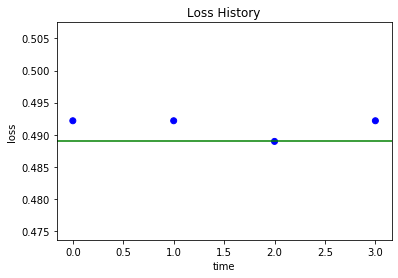

In [52]:
main_plot_history(xgb_opt[1])

Showing Histogram of 4 jobs


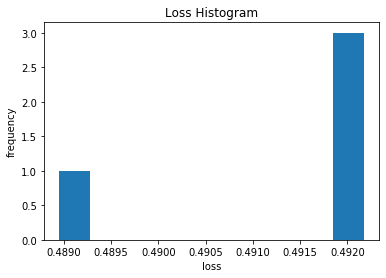

In [53]:
main_plot_histogram(xgb_opt[1])

In [54]:
xgb_opt

({'scale_pos_weight': 1}, <hyperopt.base.Trials at 0x7f5529374090>)

In [67]:
# # Define objective function
# def objective(x):
#     return {'loss': 1 - auc, 'status': STATUS_OK}

# # Run hyperopt optimization
# trials = Trials()
# result = fmin(
#     fn=objective,               
#     space=hp.uniform('x', -1, 1),   # parameter space
#     algo=tpe.suggest,               # surrogate algorithm
#     max_evals=500,                  # no. of evaluations
#     trials=trials                   # trials object that keeps track of the sample results (optional)
# )

# # Print the optimized parameters
# print(result)

# # Extract and plot the trials 
# x = trials.vals['x']
# y = [x['loss'] for x in trials.results]
# plt.scatter(x, y)

## ROC AUC Curve

In [68]:
# X = train.drop(drop_features, axis = 1)
# train_features = X.columns.values
# y = train[['death_in_next_window']]
# X = np.array(X)
# y = np.array(y).ravel()

In [82]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

In [35]:
# Convert data into XGBoost format
d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
d_valid = xgb.DMatrix(X_valid, y_valid, feature_names=train_features)

In [101]:
best_tree = xgb_model.best_ntree_limit
best_tree = 16
train_preds = xgb_model.predict(d_train, ntree_limit=best_tree)
valid_preds = xgb_model.predict(d_valid, ntree_limit=best_tree)

In [102]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import plot_roc_curve  # only sklearn after version 0.22 
from sklearn.metrics import precision_recall_curve
from scikitplot.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [103]:
print('Train AUC =',roc_auc_score(y_train, train_preds))
print('Valid AUC =',roc_auc_score(y_valid, valid_preds))

Train AUC = 0.4511737200075571
Valid AUC = 0.50912638469285


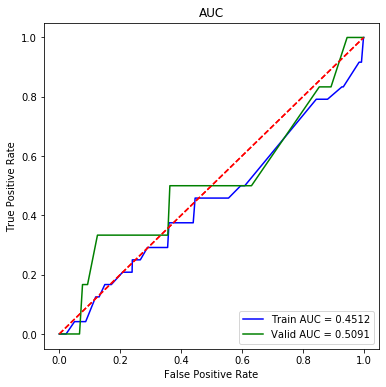

In [105]:
ax = buildROC(y_train, train_preds, label='Train')
ax = buildROC(y_valid, valid_preds, label='Valid', color='g')

## Feature Importance

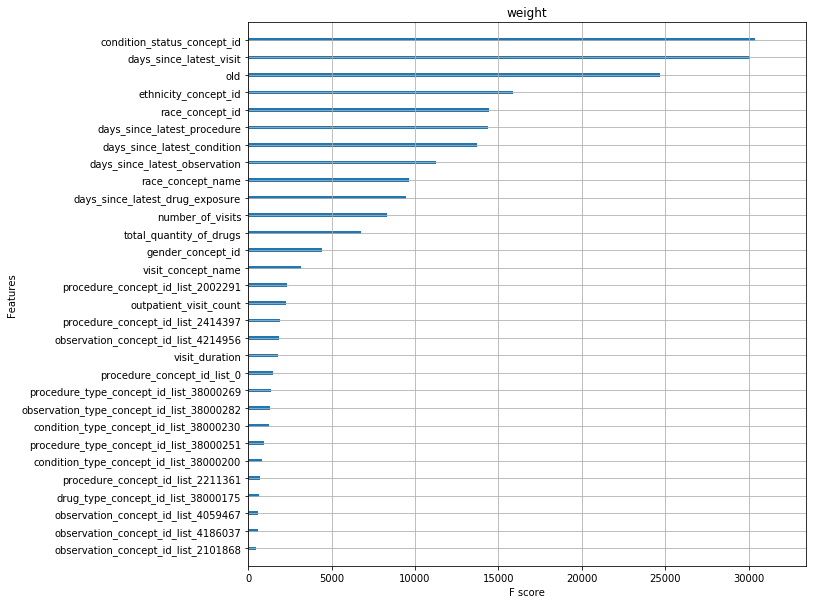

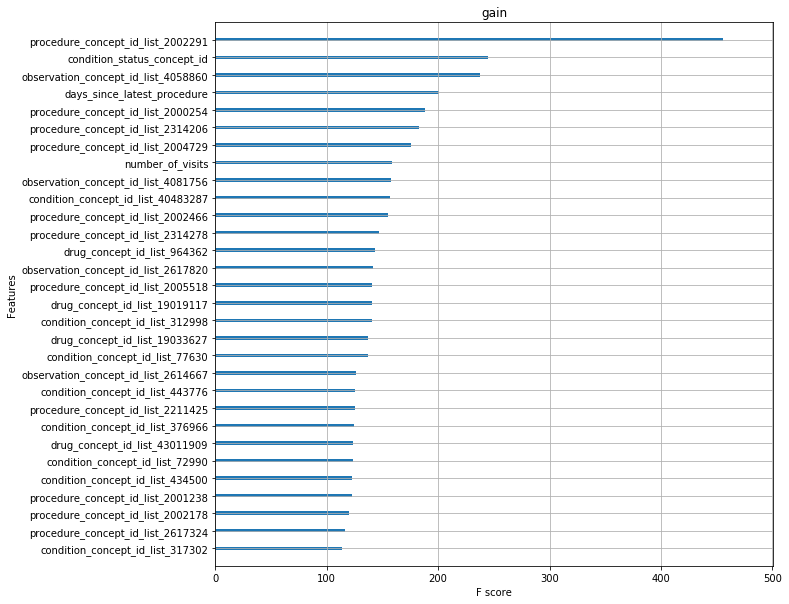

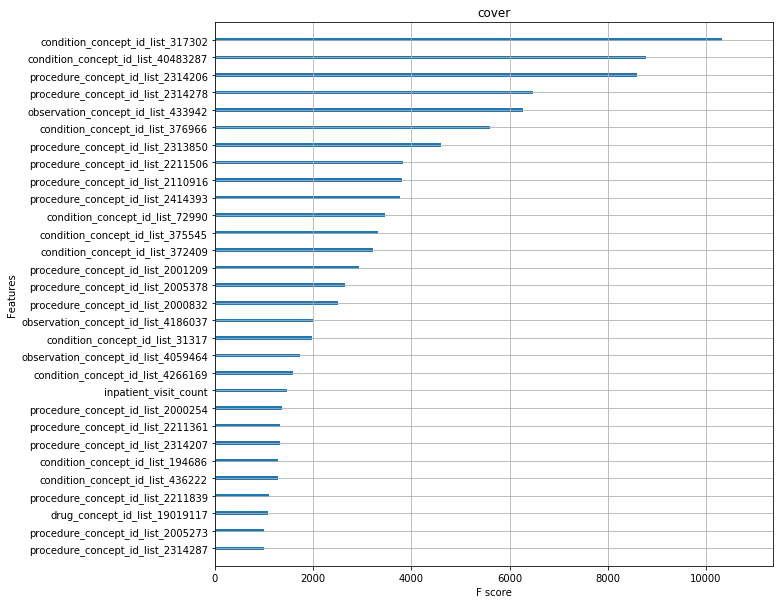

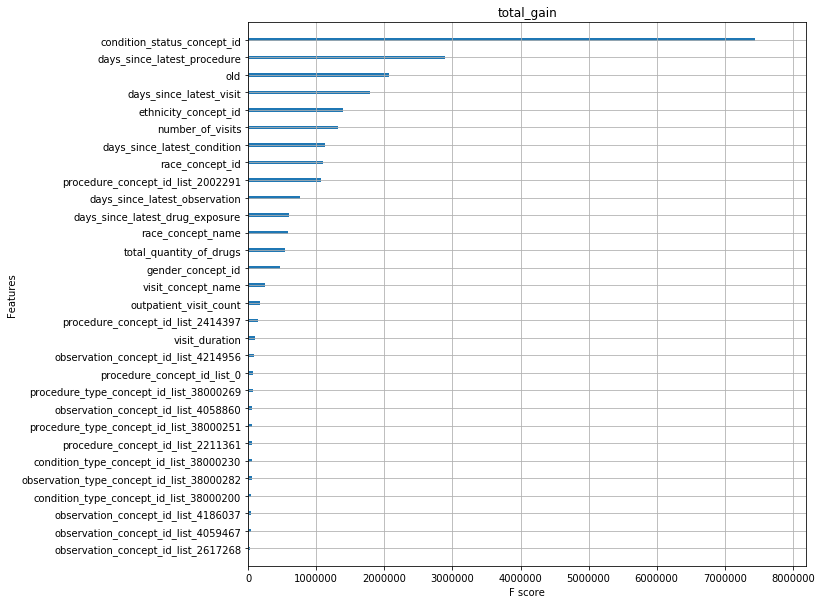

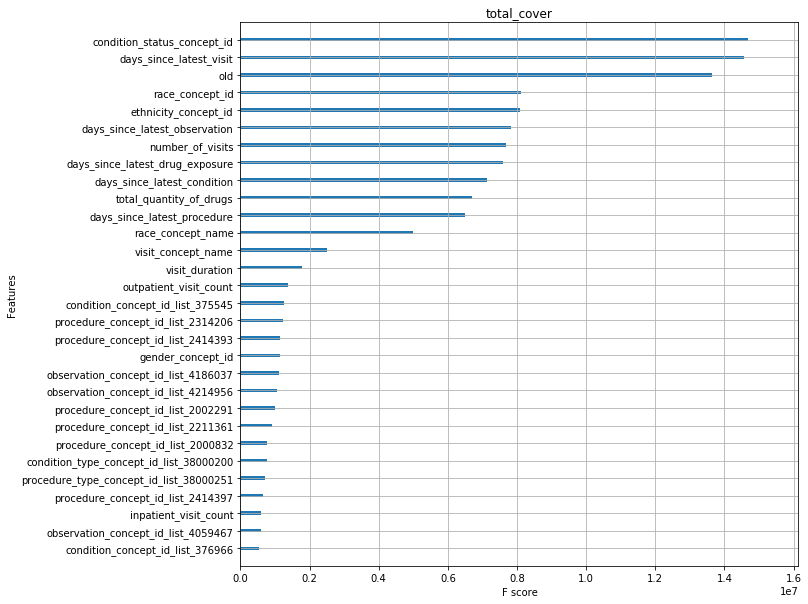

In [51]:
plt.rcParams["figure.figsize"] = (10,10)
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for i in importance_types:
    ax = xgb.plot_importance(xgb_model, importance_type=i, max_num_features=30, title=i, show_values=False)

In [52]:
for idx, i in enumerate(importance_types):
    i_dict = xgb_model.get_score(importance_type=i)
    i_df = pd.DataFrame.from_dict(i_dict.items())
    i_df.columns=['feature',i]
    if idx == 0:
        importance = i_df
    else:
        importance = importance.combine_first(i_df) #, on='feature', how='outer', suffixes=(False, False))

importance = importance.set_index('feature')
importance = importance[importance_types]
importance = importance.sort_values(by='weight', ascending=False)
importance = importance.round(2)
importance.head(10)

,weight,gain,cover,total_gain,total_cover
feature,,,,,
condition_status_concept_id,30409,245.03,482.54,7451164.58,14673701.39
days_since_latest_visit,30082,59.48,484.55,1789244.72,14576340.37
old,24688,83.98,552.02,2073413.59,13628273.03
ethnicity_concept_id,15867,88.05,509.64,1397093.22,8086394.43
race_concept_id,14451,76.47,562.34,1105041.44,8126337.56
days_since_latest_procedure,14402,200.51,450.96,2887795.33,6494759.82
days_since_latest_condition,13701,82.07,521.50,1124378.09,7145067.85
days_since_latest_observation,11238,68.26,695.47,767092.07,7815706.19
race_concept_name,9648,60.78,517.69,586437.63,4994661.37


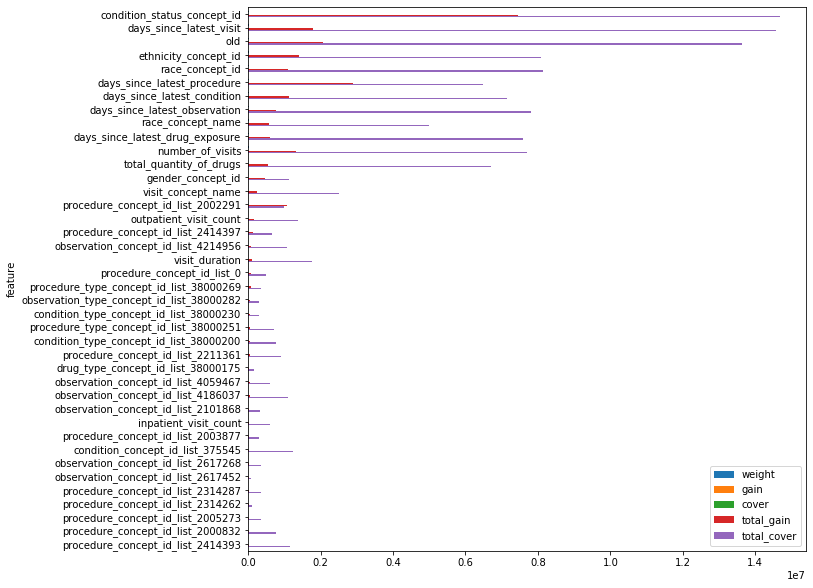

In [53]:
ax = importance[:40].plot.barh()
ax.invert_yaxis()

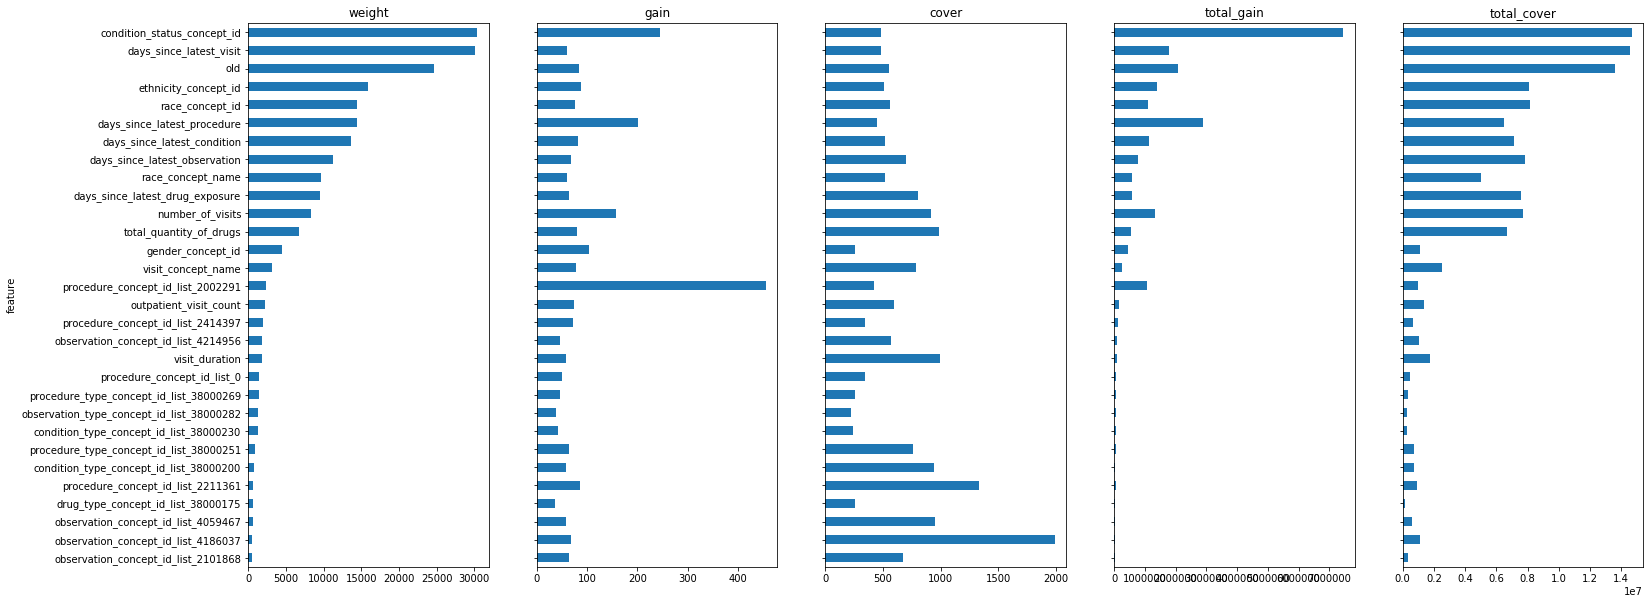

In [54]:
fig, axs = plt.subplots(1, len(importance_types), sharey=True, figsize=(len(importance_types)*5,10))
for idx, i in enumerate(importance_types):
    importance[i][:30].plot.barh(title=i, ax=axs[idx])
    axs[idx].invert_yaxis()
plt.show()

In [55]:
importance = importance.join(col_concepts.set_index('column'),how='left') #.sort_values(by='weight', ascending=False)
importance[:50]

NameError: name 'col_concepts' is not defined

In [81]:
observation = pd.read_csv('v2/app/concept_codes_final/observation_concepts.csv')
observation.head()

,observation_concept_id,concept_name,vocabulary_id
0,313232,Hemodialysis-associated hypotension,SNOMED
1,432454,Excessive thirst,SNOMED
2,141693,Elevated blood-pressure reading without diagno...,SNOMED
3,379831,Unilateral neural hearing loss,SNOMED
4,433496,Unilateral sensory hearing loss,SNOMED


In [82]:
observation[observation.observation_concept_id == 4058860]

,observation_concept_id,concept_name,vocabulary_id


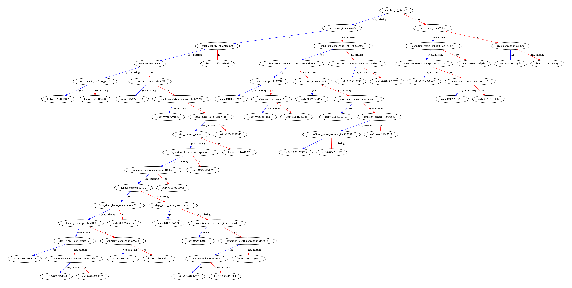

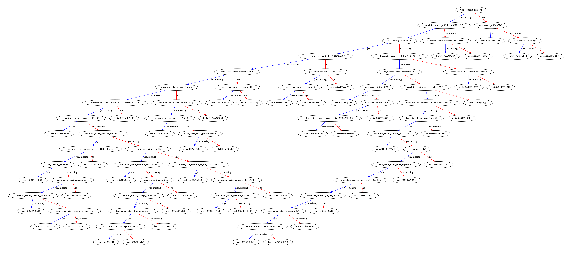

In [56]:
for k in range(30,32):
    ax = xgb.plot_tree(xgb_model,num_trees=k)
    plt.show()

In [57]:
raise Exception('STOP HERE - NOTHING WORKS PAST THIS POINT')

Exception: STOP HERE - NOTHING WORKS PAST THIS POINT

## SHAP explanations - doesn't work, tree too big
-  https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

In [103]:
# # # !pip install shap
# import shap
# shap.__version__

'0.34.0'

In [104]:
# X = train[train.window_id == w] #[train.columns[:50]]
# y = X.death_in_next_window
# X = X.drop(drop_features, axis = 1)
# train_features = X.columns.values
# X = np.array(X)
# y = np.array(y).ravel()

In [1]:
# explainer = shap.TreeExplainer(xgb_model)

In [2]:
# shap_values = explainer.shap_values(X)

In [5]:
# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

## LGBM

In [167]:
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = 'auc'                   # faster with fewer metrics to calc
# metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'learning_rate': 0.05,
    'is_unbalance': True,
    'class_weight': 'balanced'    
}


In [168]:
# https://scikit-learn.org/stable/modules/calibration.html

In [169]:
window = {}
xgb_model = None # clear out the xgb_model
for w in train.window_id.unique():
    X = train[train.window_id == w] #[train.columns[:50]]
    y = X.death_in_next_window
    window[w] = {'size': y.shape[0], 'deaths': y.sum()}
    X = X.drop(drop_features, axis = 1)
    train_features =list(X.columns)
    categorical_feature=list(range(16,len(train.columns)))
    X = np.array(X)
    y = np.array(y).ravel()
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    cv_scores = {}
    for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        evals_result ={}
        # Convert our data into XGBoost format
#         d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
#         d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
    break

/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 1

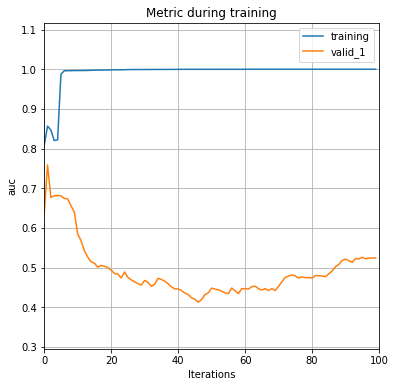

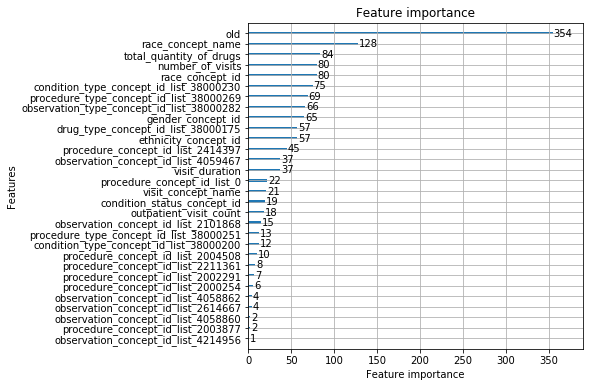

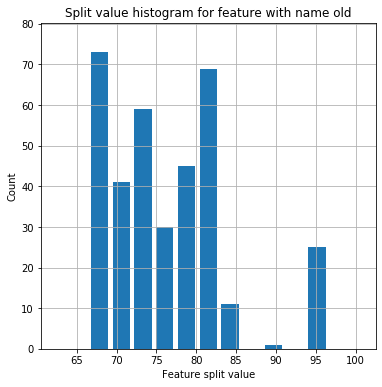

In [173]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train, feature_name=train_features, categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'task': 'train',
    'device': 'gpu',
    'metric': ['binary_logloss','auc'],
    'n_estimators': 100,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': 0
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params,
                lgb_train,
#                num_boost_round=100,
                valid_sets=[lgb_train, lgb_valid],
                evals_result=evals_result,
                early_stopping_rounds=early_stop,
                verbose_eval=0)

ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

ax = lgb.plot_split_value_histogram(gbm, feature='old', bins='auto')
plt.show()

# print('Plotting 54th tree...')  # one tree use categorical feature to split
# ax = lgb.plot_tree(gbm, tree_index=53, figsize=(15, 15), show_info=['split_gain'])
# plt.show()

# print('Plotting 54th tree with graphviz...')
# graph = lgb.create_tree_digraph(gbm, tree_index=53, name='Tree54')
# graph.render(view=True)


In [178]:
gbm.best_iteration

100

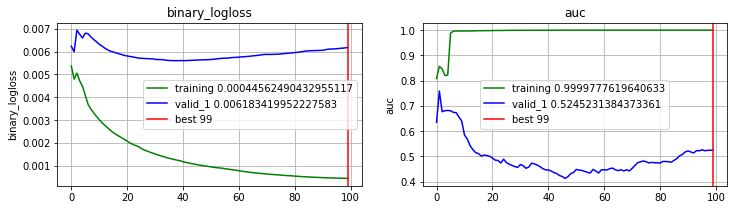

In [179]:
plot_perf(evals_result, gbm.best_iteration-1)

In [109]:
# import lightgbm as lgb

# params = {
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'n_estimators': 20,
# }

# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': ['binary_logloss','auc'],
#     'n_estimators': 20,
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 1
# }

# gbm = lgb.LGBMClassifier(**params)

# gbm.fit(X_train, y_train,
#         eval_set=[(X_train, y_train),(X_valid, y_valid)],
# #        eval_metric='auc',
#         early_stopping_rounds=10)

# print('Starting predicting...')
# # predict
# y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)
# # eval
# print('AUC: ', roc_auc_score(y_valid, y_pred))


## Eval Test 

In [107]:
# Predict on test data
d_test = xgb.DMatrix(X_test, y_test, feature_names=train_features)
preds = xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit)

In [108]:
y_scores = preds

In [109]:
print('AUC =',roc_auc_score(y_test.values, y_scores))

AUC = 0.5728509210265466


In [110]:
average_precision = average_precision_score(y_test, y_scores)
print('PRAUC = ', average_precision)

PRAUC =  0.0019102585253601625


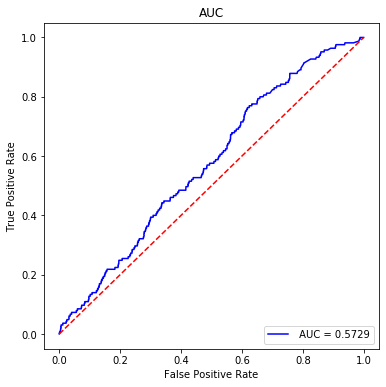

In [111]:
buildROC(y_test.values, preds, label='')

In [72]:
# # only good with sklearn API

# fig, ax = plt.subplots()
# plot_roc_curve(xgb_model, X_test, y_test, ax=ax)
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

# ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#        title="AUC")
# ax.legend(loc="lower right")
# plt.show()

In [65]:
# import scikitplot as skplt
# plt.rcParams["figure.figsize"] = (10,10)
# skplt.metrics.plot_roc(y_test, preds)

## Full train

In [46]:
# select features
drop_features = ['death_in_next_window', 'window_id', 'person_id']

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

In [53]:
len(y)

278998

In [54]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 79
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 15,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 500,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.7,
    'subsample' : 1.0,
    'missing': 0,
}

In [63]:
d_train_full = xgb.DMatrix(X, y, feature_names=train_features)
xgb_model = xgb.train(params, d_train_full, num_boost_round=num_round, maximize=True, 
                      verbose_eval=False, callbacks=[xgb_progressbar(num_round), ])

In [58]:
d_test = xgb.DMatrix(X_test, y_test, feature_names=test_features)
train_preds = xgb_model.predict(d_train_full, ntree_limit=xgb_model.best_ntree_limit)
test_preds = xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit)

In [60]:
print('Train AUC =',roc_auc_score(y, train_preds))
print('Valid AUC =',roc_auc_score(y_test, test_preds))

Train AUC = 0.9820409272365556
Valid AUC = 0.5887798620861614


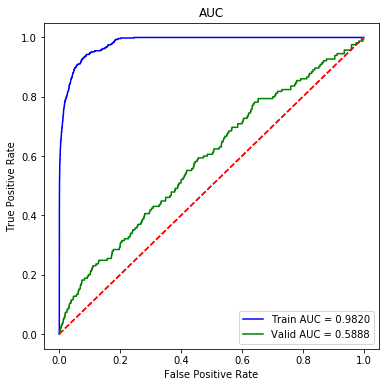

In [62]:
ax = buildROC(y, train_preds, label='Train')
ax = buildROC(y_test, test_preds, label='Valid', color='g')

## Test saving and loading the model

In [64]:
model_file = 'xgb_model.joblib'
dump(xgb_model, model_file)

['xgb_model.joblib']

In [65]:
xgb_model_2 = load(model_file)
type(xgb_model_2)

xgboost.core.Booster

## Old StratifiedShuffleSplit XGB

In [18]:
raise # stop here

RuntimeError: No active exception to reraise

In [75]:
# select features
drop_features = ['death_in_next_window', 'person_id'] # 'window_id', 

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train[['death_in_next_window']]
X = np.array(X)
y = np.array(y).ravel()

In [89]:
%%time
splits=3
cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_state)
window = {}
cv_scores = {}
for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    window[i] = {'size': y.shape[0], 'deaths': y.sum()}
    evals_result ={}
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
    d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                          evals=watchlist, evals_result=evals_result, 
                          early_stopping_rounds=early_stop, verbose_eval=False,
                          callbacks=[ xgb_progressbar(num_round),])  
    
    cv_scores[i] = {'best_score': xgb_model.best_score, 
                    'best_iteration': xgb_model.best_iteration, 
                    'best_ntree_limit': xgb_model.best_ntree_limit,
                    'evals_result': evals_result}
    window[0].update(cv_scores)

    print("Best Score:%f, best iteration:%d, best ntree:%d" % 
          (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))


Best Score:0.526464, best iteration:0, best ntree:1


Best Score:0.556530, best iteration:126, best ntree:127


Best Score:0.517950, best iteration:13, best ntree:14
CPU times: user 2min 43s, sys: 6.01 s, total: 2min 49s
Wall time: 24.2 s


In [352]:
window = {}
window[0] = {'size': y.shape[0], 'deaths': y.sum()}
window[0].update(cv_scores)
window[1] = {'size': y.shape[0], 'deaths': y.sum()}
window[1].update(cv_scores)

In [ ]:
# prep a df to plot the learning curve
w_df = pd.DataFrame(cv_scores)
w_df.loc['cv_av_score'] = 0
w_df.loc['cum_size'] = 0

In [111]:
cv_av_score = 0
for s in range(splits):
    cv_av_score += w_df.loc['best_score',s]
cv_av_score = cv_av_score / 3
w_df.loc['cv_av_score',s] = cv_av_score

for j in w_df.columns:
    if j != 0:
        w_df.loc['cum_size',j] = w_df.loc['size',j] + w_df.loc['cum_size',j-1] 
    else:
        w_df.loc['cum_size',j] = w_df.loc['size',j]

KeyError: 'size'

In [40]:
for s in w_df.columns:
    plot_perf(w_df.loc['evals_result',s], w_df.loc['best_iteration',s])

KeyError: 'evals_result'